In [248]:
import re
from tqdm.notebook import tqdm

from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

from covid_flu import config, utils, time_series, plotting

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
HISTORY_SIZE = 25
TARGET_SIZE = 1
EPOCHS=10

In [75]:
df_flu = pd.read_csv(config.processed / 'flu_ground_truth_imputed.csv')

In [77]:
df_flu.head(5)

,time,wili,state
0,2010-40,2.06514,Texas
1,2010-41,2.09394,Texas
2,2010-42,2.10072,Texas
3,2010-43,2.20655,Texas
4,2010-44,2.36381,Texas


In [78]:
df_flu.shape

(23050, 3)

In [79]:
X = df_flu['wili'].values
groups = df_flu['state'].values
sc = StandardScaler()
X_scaled = sc.fit_transform(X.reshape(-1,1)).flatten()

In [80]:
df_flu['wili_scaled'] = X_scaled

In [83]:
ds_train, ds_val, ds_test, data_dict = time_series.prepare_data(X_scaled, 
                                                                groups,
                                                                history_size=HISTORY_SIZE, 
                                                                target_size=TARGET_SIZE, 
                                                                test_size=0.2)

In [84]:
#create arrays for testing later
X_test = data_dict['X_test']
y_test = data_dict['y_test']
states_test = data_dict['states_test']

In [86]:
def make_simple_lstm(history_length=25, target_length=1, num_lstm_layers=2, hidden_size=32, pre_output_dense_size=16):
    simple_lstm = tf.keras.models.Sequential()
    for i in range(num_lstm_layers):
        if i==0:
            simple_lstm.add(layers.LSTM(hidden_size, activation='relu', input_shape=(history_length,1), return_sequences=True))
        elif i==num_lstm_layers-1:
            simple_lstm.add(layers.LSTM(hidden_size, activation='relu'))
        else:
            simple_lstm.add(layers.LSTM(hidden_size, activation='relu', return_sequences=True))
    if pre_output_dense_size!=None:
        simple_lstm.add(layers.Dense(pre_output_dense_size, activation='relu'))
    simple_lstm.add(layers.Dense(target_length))
    simple_lstm.compile(optimizer='adam', loss='mse')
    return simple_lstm

## Simple LSTM for one step prediction 

In [88]:
simple_lstm = make_simple_lstm(num_lstm_layers=3,hidden_size=32,pre_output_dense_size=32)

In [89]:
simple_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 25, 32)            4352      
_________________________________________________________________
lstm_13 (LSTM)               (None, 25, 32)            8320      
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 22,081
Trainable params: 22,081
Non-trainable params: 0
_________________________________________________________________


In [90]:
history_simplelstm = simple_lstm.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
68/68 [==============================] - 10s 149ms/step - loss: 0.6132 - val_loss: 0.0000e+00
Epoch 2/10
68/68 [==============================] - 6s 84ms/step - loss: 0.2651 - val_loss: 0.4691
Epoch 3/10
68/68 [==============================] - 6s 87ms/step - loss: 0.1436 - val_loss: 0.2452
Epoch 4/10
68/68 [==============================] - 6s 85ms/step - loss: 0.1134 - val_loss: 0.2337
Epoch 5/10
68/68 [==============================] - 6s 84ms/step - loss: 0.1063 - val_loss: 0.1915
Epoch 6/10
68/68 [==============================] - 6s 87ms/step - loss: 0.1037 - val_loss: 0.1941
Epoch 7/10
68/68 [==============================] - 6s 83ms/step - loss: 0.1030 - val_loss: 0.2033
Epoch 8/10
68/68 [==============================] - 6s 85ms/step - loss: 0.1027 - val_loss: 0.1907
Epoch 9/10
68/68 [==============================] - 6s 84ms/step - loss: 0.0990 - val_loss: 0.1824
Epoch 10/10
68/68 [==============================] - 6s 85ms/step - loss: 0.0999 - val_loss: 0.1842


In [91]:
simple_lstm.evaluate(ds_test)

9/9 [==============================] - 0s 38ms/step - loss: 0.1063


0.10629502849446403

In [96]:
def calc_rmse_model(y_true, x, model, history_length, scaler=None):
    #calculates unscaled RMSE for a model on a test set
    preds = model.predict(x)
    if scaler!=None:
        y_true = scaler.inverse_transform(y_true.flatten())
        preds = scaler.inverse_transform(preds)
    return calculate_rmse(y_true, preds)
        

In [97]:
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

In [98]:
calc_rmse_model(y_test, X_test, simple_lstm, HISTORY_SIZE, sc)

0.5885452046128002

In [162]:
def plot_preds_for_state(X_test, y_test, states_test, model, history_length, state, scaler=None):
    preds = model.predict(X_test[states_test==state])
    y = y_test[states_test==state].flatten()
    if scaler!=None:
        y = scaler.inverse_transform(y_test[states_test==state].flatten())
        preds = scaler.inverse_transform(preds)
    
    print(f"RMSE = {calculate_rmse(y, preds)}")
    
    plt.figure(figsize=(10,8))
    plt.plot(y, 'b-', label='True')
    plt.plot(preds, 'r-', label='Predicted')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('WILI')
    plt.title(f'True vs Predicted for {state}')
    plt.show()

RMSE = 0.41267382983476325


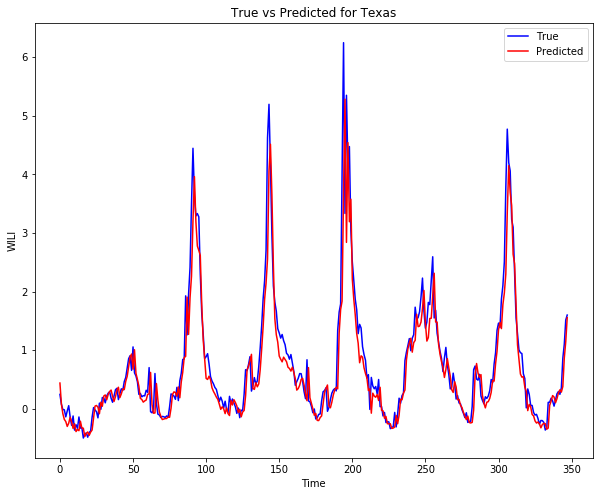

In [100]:
plot_preds_for_state(data_dict['X_train'], data_dict['y_train'], data_dict['states_train'], simple_lstm, HISTORY_SIZE, 'Texas')

RMSE = 0.29250209964205665


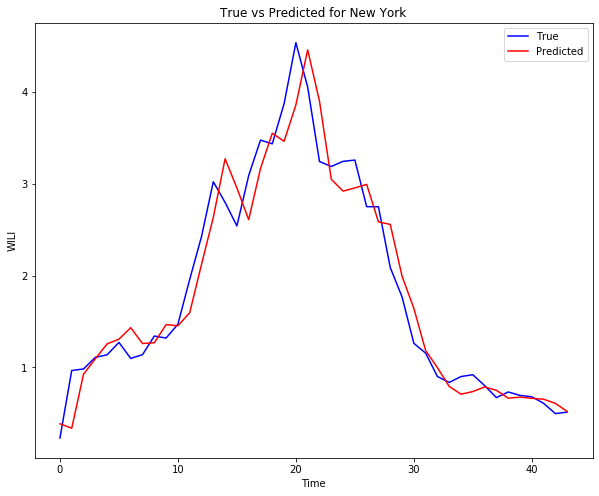

In [101]:
plot_preds_for_state(X_test, y_test, states_test, simple_lstm, HISTORY_SIZE, 'New York', sc)


## Decreasing history size and retrying

In [103]:
HISTORY_SIZE = 10
ds_train, ds_val, ds_test, data_dict = time_series.prepare_data(X_scaled, 
                                                                groups,
                                                                history_size=HISTORY_SIZE, 
                                                                target_size=TARGET_SIZE, 
                                                                test_size=0.2)
X_test = data_dict['X_test']
y_test = data_dict['y_test']
states_test = data_dict['states_test']

In [105]:
simple_lstm_10 = make_simple_lstm(history_length=HISTORY_SIZE, num_lstm_layers=3,hidden_size=32,pre_output_dense_size=32)

In [106]:
simple_lstm_10.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 10, 32)            4352      
_________________________________________________________________
lstm_16 (LSTM)               (None, 10, 32)            8320      
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 22,081
Trainable params: 22,081
Non-trainable params: 0
_________________________________________________________________


In [107]:
history_simplelstm10 = simple_lstm_10.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
71/71 [==============================] - 7s 92ms/step - loss: 0.6214 - val_loss: 0.0000e+00
Epoch 2/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1991 - val_loss: 0.2515
Epoch 3/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1243 - val_loss: 0.2513
Epoch 4/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1135 - val_loss: 0.1990
Epoch 5/10
71/71 [==============================] - 3s 40ms/step - loss: 0.1116 - val_loss: 0.2187
Epoch 6/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1084 - val_loss: 0.1832
Epoch 7/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1080 - val_loss: 0.1908
Epoch 8/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1068 - val_loss: 0.2105
Epoch 9/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1109 - val_loss: 0.1992
Epoch 10/10
71/71 [==============================] - 3s 36ms/step - loss: 0.1069 - val_loss: 0.1916


In [108]:
calc_rmse_model(y_test, X_test, simple_lstm_10, HISTORY_SIZE, sc)

0.5916566604722716

RMSE = 0.2984078758219067


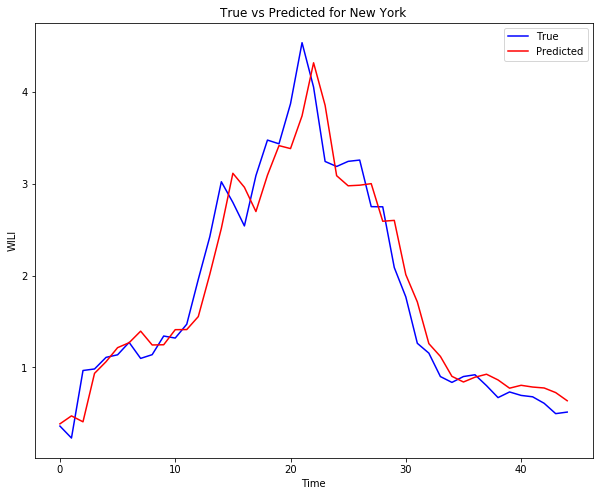

In [109]:
plot_preds_for_state(X_test, y_test, states_test, simple_lstm_10, HISTORY_SIZE, 'New York', sc)

## Increasing history size and retrying

In [110]:
HISTORY_SIZE = 50

In [111]:
ds_train, ds_val, ds_test, data_dict = time_series.prepare_data(X_scaled, 
                                                                groups,
                                                                history_size=HISTORY_SIZE, 
                                                                target_size=TARGET_SIZE, 
                                                                test_size=0.2)

In [112]:
X_test = data_dict['X_test']
y_test = data_dict['y_test']
states_test = data_dict['states_test']

In [113]:
X_test.shape

(2050, 50, 1)

In [114]:
y_test.shape

(2050, 1, 1)

In [115]:
simple_lstm50 = make_simple_lstm(history_length=HISTORY_SIZE, num_lstm_layers=3,hidden_size=32,pre_output_dense_size=32)

In [117]:
simple_lstm50.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 50, 32)            4352      
_________________________________________________________________
lstm_19 (LSTM)               (None, 50, 32)            8320      
_________________________________________________________________
lstm_20 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 22,081
Trainable params: 22,081
Non-trainable params: 0
_________________________________________________________________


In [118]:
history_simplelstm50 = simple_lstm50.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
65/65 [==============================] - 15s 235ms/step - loss: 0.6905 - val_loss: 0.0000e+00
Epoch 2/10
65/65 [==============================] - 11s 167ms/step - loss: 0.2976 - val_loss: 0.3749
Epoch 3/10
65/65 [==============================] - 11s 166ms/step - loss: 0.1871 - val_loss: 0.1833
Epoch 4/10
65/65 [==============================] - 11s 165ms/step - loss: 0.1418 - val_loss: 0.2007
Epoch 5/10
65/65 [==============================] - 11s 168ms/step - loss: 0.1212 - val_loss: 0.1256
Epoch 6/10
65/65 [==============================] - 11s 168ms/step - loss: 0.1109 - val_loss: 0.1302
Epoch 7/10
65/65 [==============================] - 11s 163ms/step - loss: 0.1093 - val_loss: 0.1303
Epoch 8/10
65/65 [==============================] - 11s 168ms/step - loss: 0.1073 - val_loss: 0.1274
Epoch 9/10
65/65 [==============================] - 11s 167ms/step - loss: 0.1040 - val_loss: 0.1108
Epoch 10/10
65/65 [==============================] - 11s 168ms/step - loss: 0.1072 - va

In [120]:
calc_rmse_model(y_test, X_test, simple_lstm50, HISTORY_SIZE, sc)

0.5972684825604444

RMSE = 0.324613885759184


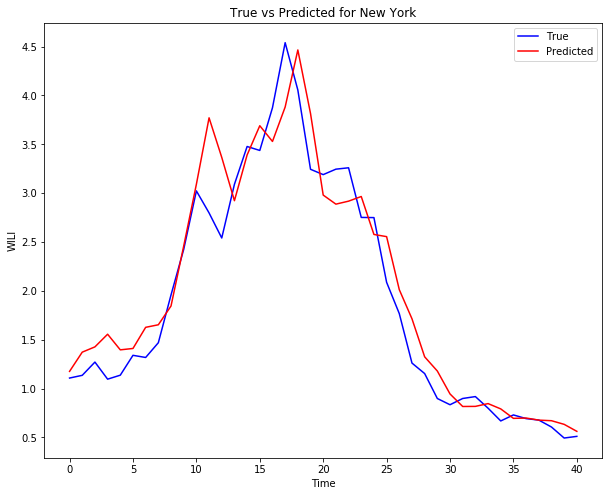

In [121]:
plot_preds_for_state(X_test, y_test, states_test, simple_lstm50, HISTORY_SIZE, 'New York', sc)


## Multi-step time series forecasting

Given H previous weeks predict next T weeks.

In this task we want to evaluate the model on how well it is able to predict the next couple of weeks. Hence we measure the RMSE for each of the next T steps of the multi-step prediction. This will allows us to see which models have better predictive accuracy at different lead times (e.g. +1 week vs +4 weeks).

We might favor a model which is slightly worse in predicting next week but much better in predicting the next couple of weeks.


In [275]:
HISTORY_SIZE = 25
TARGET_SIZE = 5

In [276]:
ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.3)

In [277]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [125]:
X_test.shape

(3250, 25, 1)

In [126]:
y_test.shape

(3250, 5, 1)

## Simple LSTM with vector output

In [127]:
simple_lstm_multi = make_simple_lstm(history_length=HISTORY_SIZE, target_length=TARGET_SIZE, num_lstm_layers=2, hidden_size=32, pre_output_dense_size=16)


In [128]:
simple_lstm_multi.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 25, 32)            4352      
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 85        
Total params: 13,285
Trainable params: 13,285
Non-trainable params: 0
_________________________________________________________________


In [129]:
simple_lstm_multi.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
236/236 [==============================] - 17s 71ms/step - loss: 0.4580 - val_loss: 0.0000e+00
Epoch 2/10
236/236 [==============================] - 14s 58ms/step - loss: 0.2609 - val_loss: 0.6924
Epoch 3/10
236/236 [==============================] - 14s 58ms/step - loss: 0.2528 - val_loss: 0.6594
Epoch 4/10
236/236 [==============================] - 14s 58ms/step - loss: 0.2465 - val_loss: 0.6538
Epoch 5/10
236/236 [==============================] - 14s 58ms/step - loss: 0.2403 - val_loss: 0.6116
Epoch 6/10
236/236 [==============================] - 14s 58ms/step - loss: 0.2350 - val_loss: 0.5963
Epoch 7/10
236/236 [==============================] - 14s 58ms/step - loss: 0.2330 - val_loss: 0.6229
Epoch 8/10
236/236 [==============================] - 14s 58ms/step - loss: 0.2308 - val_loss: 0.5996
Epoch 9/10
236/236 [==============================] - 14s 58ms/step - loss: 0.2279 - val_loss: 0.5764
Epoch 10/10
236/236 [==============================] - 14s 58ms/step - loss: 0

In [143]:
def evaluate_multiple_steps_preds(y_true, predicted, scaler):
    #calculate the rmse for each for each of the steps individualy (i.e. error for one week ahead, 2 weeks ahead and so on)
    if scaler!=None:
        y_true = scaler.inverse_transform(y_true)
        predicted = scaler.inverse_transform(predicted)
    rmses = []
    for i in range(predicted.shape[1]):
        rmse_step = calculate_rmse(y_true[:,i], predicted[:,i])
        rmses.append(rmse_step)
    rmses = np.array(rmses)
    return rmses, rmses.mean()

In [132]:
test_preds = simple_lstm_multi.predict(X_test)

In [145]:
evaluate_multiple_steps_preds(y_test.reshape(-1,TARGET_SIZE), test_preds, sc)

(array([0.5359699 , 0.73446397, 0.88623361, 1.00980357, 1.11924078]),
 0.8571423633322768)

In [167]:
def plot_multiple_steps_preds_for_state(X_test, y_test, states_test, model, target_size, state, scaler=None):
    #plot the preds for target_size weeks ahead skipping every target_size inputs 
    preds = model.predict(X_test[states_test==state])
    y = y_test[states_test==state]
    rmses, mean_rmse = evaluate_multiple_steps_preds(y, preds, scaler)
    if scaler!=None:
        y = scaler.inverse_transform(y_test[states_test==state])
        preds = scaler.inverse_transform(preds)
    
    multiple_step_preds = preds[::target_size,:].flatten()
    y = y[::target_size, :].flatten()
    
    print(f"RMSES for each step = {rmses}, average = {mean_rmse}")
    
    plt.figure(figsize=(10,8))
    plt.plot(y, 'b-', label='True')
    plt.plot(multiple_step_preds, 'r-', label='Predicted')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('WILI')
    plt.title(f'True vs {target_size}-steps prediction for {state}')
    plt.show()

RMSES for each step = [0.3488391  0.46741659 0.51327098 0.59209791 0.66805766], average = 0.5179364490782555


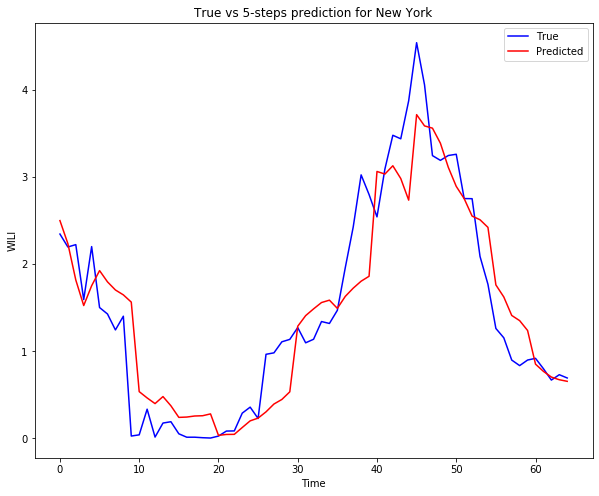

In [168]:
plot_multiple_steps_preds_for_state(X_test, y_test.reshape(-1,TARGET_SIZE), states_test, simple_lstm_multi, TARGET_SIZE, 'New York', sc)


RMSES for each step = [0.71833281 1.06435019 1.35637585 1.57095527 1.84875582], average = 1.311753990395808


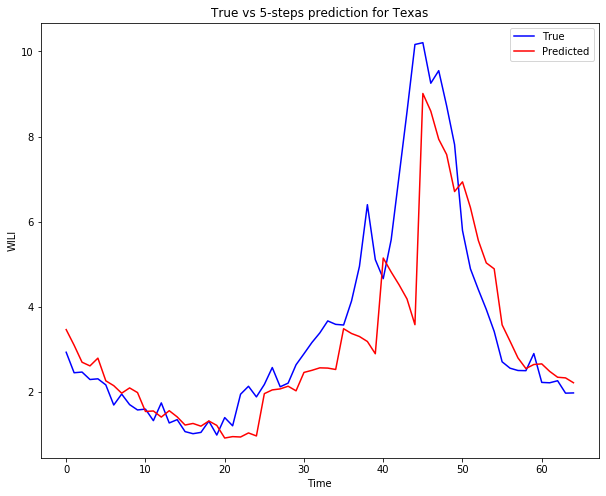

In [169]:
plot_multiple_steps_preds_for_state(X_test, y_test.reshape(-1,TARGET_SIZE), states_test, simple_lstm_multi, TARGET_SIZE, 'Texas', sc)


## Encoder-Decoder model

In [230]:
def build_simple_encoder_decoder_model(history_length=25, target_length=5, num_encoder_layers=2, num_decoder_layers=2, hidden_size=32, pre_output_dense_size=16, dropout=0):
    model = tf.keras.models.Sequential()
    #add encoder
    for i in range(num_encoder_layers):
        if i==0:
            model.add(layers.LSTM(hidden_size, activation='relu', input_shape=(history_length,1), return_sequences=True, dropout=dropout))
        elif i==num_encoder_layers-1:
            model.add(layers.LSTM(hidden_size, activation='relu', dropout=dropout))
        else:
            model.add(layers.LSTM(hidden_size, activation='relu', return_sequences=True, dropout=dropout))
    #repeat the encodings for each of the target steps        
    model.add(layers.RepeatVector(target_length))
    #add decoder
    for i in range(num_decoder_layers):
        model.add(layers.LSTM(hidden_size, activation='relu', return_sequences=True, dropout=dropout))
    if pre_output_dense_size!=None:
        model.add(layers.TimeDistributed(layers.Dense(pre_output_dense_size, activation='relu')))
    #time distribute the prediction for each step of the output sequence
    model.add(layers.TimeDistributed(layers.Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

In [180]:
simple_seq2seq = build_simple_encoder_decoder_model(history_length=HISTORY_SIZE, 
                                                    target_length=TARGET_SIZE, 
                                                    num_encoder_layers=2, 
                                                    num_decoder_layers=2, 
                                                    hidden_size=32, 
                                                    pre_output_dense_size=16)

In [181]:
simple_seq2seq.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 25, 32)            4352      
_________________________________________________________________
lstm_31 (LSTM)               (None, 32)                8320      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 32)             0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
lstm_33 (LSTM)               (None, 5, 32)             8320      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 16)             528       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 1)            

In [183]:
simple_seq2seq.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
236/236 [==============================] - 17s 71ms/step - loss: 0.2226 - val_loss: 0.0000e+00
Epoch 2/10
236/236 [==============================] - 17s 70ms/step - loss: 0.2237 - val_loss: 0.6249
Epoch 3/10
236/236 [==============================] - 17s 70ms/step - loss: 0.2205 - val_loss: 0.6808
Epoch 4/10
236/236 [==============================] - 17s 71ms/step - loss: 0.2173 - val_loss: 0.6410
Epoch 5/10
236/236 [==============================] - 17s 71ms/step - loss: 0.2165 - val_loss: 0.5874
Epoch 6/10
236/236 [==============================] - 17s 70ms/step - loss: 0.2148 - val_loss: 0.6282
Epoch 7/10
236/236 [==============================] - 17s 70ms/step - loss: 0.2120 - val_loss: 0.6171
Epoch 8/10
236/236 [==============================] - 16s 70ms/step - loss: 0.2128 - val_loss: 0.5878
Epoch 9/10
236/236 [==============================] - 17s 71ms/step - loss: 0.2106 - val_loss: 0.5792
Epoch 10/10
236/236 [==============================] - 17s 70ms/step - loss: 0

In [188]:
test_preds = simple_seq2seq.predict(X_test)
evaluate_multiple_steps_preds(y_test.reshape(-1,TARGET_SIZE), test_preds.reshape(-1,TARGET_SIZE), sc)

(array([0.5287733 , 0.7348553 , 0.89809379, 1.01700954, 1.10492268]),
 0.8567309201465031)

## Different structure of encoder: more breadth

In [196]:
simple_seq2seq2 = build_simple_encoder_decoder_model(history_length=HISTORY_SIZE, 
                                                    target_length=TARGET_SIZE, 
                                                    num_encoder_layers=2, 
                                                    num_decoder_layers=2, 
                                                    hidden_size=100, 
                                                    pre_output_dense_size=16)

In [197]:
simple_seq2seq2.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
236/236 [==============================] - 23s 98ms/step - loss: 1.0647 - val_loss: 0.0000e+00
Epoch 2/10
236/236 [==============================] - 18s 74ms/step - loss: 0.2758 - val_loss: 0.6322
Epoch 3/10
236/236 [==============================] - 18s 74ms/step - loss: 0.2456 - val_loss: 0.6287
Epoch 4/10
236/236 [==============================] - 18s 75ms/step - loss: 0.2402 - val_loss: 0.6530
Epoch 5/10
236/236 [==============================] - 18s 74ms/step - loss: 0.2416 - val_loss: 0.6059
Epoch 6/10
236/236 [==============================] - 18s 74ms/step - loss: 0.2284 - val_loss: 0.5912
Epoch 7/10
236/236 [==============================] - 18s 74ms/step - loss: 0.2336 - val_loss: 0.6257
Epoch 8/10
236/236 [==============================] - 18s 74ms/step - loss: 0.2252 - val_loss: 0.6037
Epoch 9/10
236/236 [==============================] - 18s 75ms/step - loss: 0.2209 - val_loss: 0.5591
Epoch 10/10
236/236 [==============================] - 18s 75ms/step - loss: 0

In [198]:
test_preds = simple_seq2seq2.predict(X_test)
evaluate_multiple_steps_preds(y_test.reshape(-1,TARGET_SIZE), test_preds.reshape(-1,TARGET_SIZE), sc)

(array([0.56430656, 0.73720345, 0.88767306, 1.00287894, 1.08647392]),
 0.8557071867649462)

RMSES for each step = [0.44392127 0.51470447 0.55137072 0.59265029 0.63676896], average = 0.5478831408386892


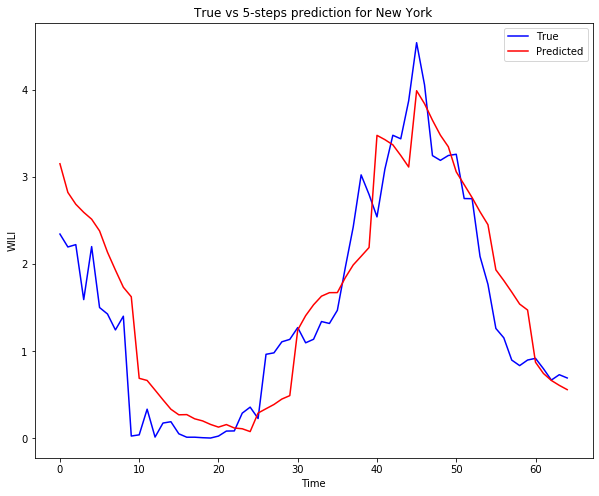

In [199]:
plot_multiple_steps_preds_for_state(X_test, y_test.reshape(-1,TARGET_SIZE), states_test, simple_seq2seq2, TARGET_SIZE, 'New York', sc)


RMSES for each step = [0.72918426 1.03925524 1.29602645 1.51150658 1.6720705 ], average = 1.249608603259887


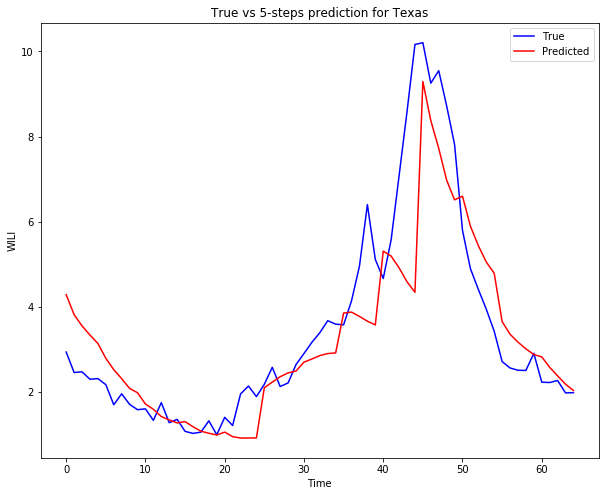

In [200]:
plot_multiple_steps_preds_for_state(X_test, y_test.reshape(-1,TARGET_SIZE), states_test, simple_seq2seq2, TARGET_SIZE, 'Texas', sc)


In [211]:
X_all = np.concatenate((data_dict_multi['X_train'],data_dict_multi['X_val'], data_dict_multi['X_test']))
y_all = np.concatenate((data_dict_multi['y_train'],data_dict_multi['y_val'], data_dict_multi['y_test']))
states_all = np.concatenate((data_dict_multi['states_train'],data_dict_multi['states_val'], data_dict_multi['states_test']))


RMSES for each step = [0.82836404 1.21604455 1.47946958 1.71395312 1.89261384], average = 1.4260890243422224


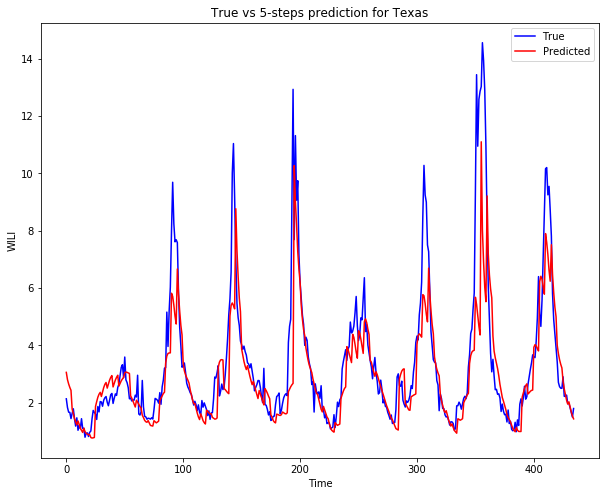

In [215]:
plot_multiple_steps_preds_for_state(X_all, y_all.reshape(-1,TARGET_SIZE), states_all, simple_seq2seq2, TARGET_SIZE, 'Texas', sc)


RMSES for each step = [0.57174304 0.82663631 0.98458725 1.11124823 1.19821304], average = 0.9384855754823602


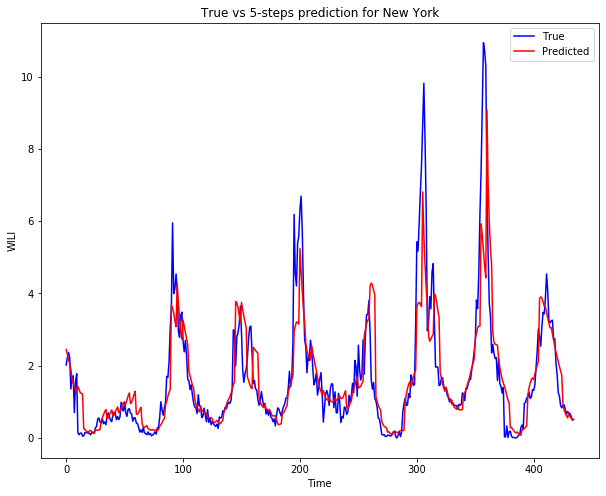

In [216]:
plot_multiple_steps_preds_for_state(X_all, y_all.reshape(-1,TARGET_SIZE), states_all, simple_seq2seq2, TARGET_SIZE, 'New York', sc)


## Different structure of encoder: more depth

In [234]:
simple_seq2seq_deeper = build_simple_encoder_decoder_model(history_length=HISTORY_SIZE, 
                                                    target_length=TARGET_SIZE, 
                                                    num_encoder_layers=4, 
                                                    num_decoder_layers=3, 
                                                    hidden_size=32, 
                                                    pre_output_dense_size=32,
                                                    dropout=0.)

In [235]:
simple_seq2seq_deeper.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
236/236 [==============================] - 41s 172ms/step - loss: 0.7997 - val_loss: 0.0000e+00
Epoch 2/20
236/236 [==============================] - 31s 133ms/step - loss: 0.5178 - val_loss: 1.2811
Epoch 3/20
236/236 [==============================] - 31s 133ms/step - loss: 0.3491 - val_loss: 0.8015
Epoch 4/20
236/236 [==============================] - 31s 133ms/step - loss: 0.2708 - val_loss: 0.6625
Epoch 5/20
236/236 [==============================] - 31s 133ms/step - loss: 0.2440 - val_loss: 0.7315
Epoch 6/20
236/236 [==============================] - 31s 133ms/step - loss: 0.2466 - val_loss: 0.6350
Epoch 7/20
236/236 [==============================] - 31s 133ms/step - loss: 0.2315 - val_loss: 0.6386
Epoch 8/20
236/236 [==============================] - 31s 133ms/step - loss: 0.2320 - val_loss: 0.6173
Epoch 9/20
236/236 [==============================] - 31s 133ms/step - loss: 0.2302 - val_loss: 0.6375
Epoch 10/20
236/236 [==============================] - 31s 133ms/step

In [236]:
test_preds = simple_seq2seq_deeper.predict(X_test)
evaluate_multiple_steps_preds(y_test.reshape(-1,TARGET_SIZE), test_preds.reshape(-1,TARGET_SIZE), sc)

(array([0.56885955, 0.744506  , 0.89973882, 1.01556375, 1.09939568]),
 0.865612761525792)

## CNN-Encoder for seq2seq model

In [201]:
def build_cnn_lstm_model(history_length=25, 
                         target_length=5, 
                         num_encoder_layers=2, 
                         num_decoder_layers=2, 
                         num_filters=64, 
                         kernel_size=3, 
                         hidden_size=32, 
                         pre_output_dense_size=16):
    model = tf.keras.models.Sequential()
    #add CNN encoder
    for i in range(num_encoder_layers):
        if i==0:
            model.add(layers.Conv1D(filters=num_filters, kernel_size=3, activation='relu', input_shape=(history_length,1)))
        else:
            model.add(layers.Conv1D(filters=num_filters, kernel_size=3, activation='relu', input_shape=(history_length,1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    #repeat the encodings for each of the target steps        
    model.add(layers.RepeatVector(target_length))
    #add decoder
    for i in range(num_decoder_layers):
        model.add(layers.LSTM(hidden_size, activation='relu', return_sequences=True))
    if pre_output_dense_size!=None:
        model.add(layers.TimeDistributed(layers.Dense(pre_output_dense_size, activation='relu')))
    #time distribute the prediction for each step of the output sequence
    model.add(layers.TimeDistributed(layers.Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    return model

In [203]:
cnn_lstm_seq2seq = build_cnn_lstm_model(history_length=HISTORY_SIZE, 
                         target_length=TARGET_SIZE, 
                         num_encoder_layers=2, 
                         num_decoder_layers=2, 
                         num_filters=64, 
                         kernel_size=3, 
                         hidden_size=32, 
                         pre_output_dense_size=16)

In [205]:
cnn_lstm_seq2seq.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 5, 640)            0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 5, 32)             86144     
_________________________________________________________________
lstm_47 (LSTM)               (None, 5, 32)           

In [206]:
cnn_lstm_seq2seq.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
236/236 [==============================] - 10s 41ms/step - loss: 0.4258 - val_loss: 0.0000e+00
Epoch 2/20
236/236 [==============================] - 4s 19ms/step - loss: 0.3123 - val_loss: 0.8650
Epoch 3/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2775 - val_loss: 0.7620
Epoch 4/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2709 - val_loss: 0.7751
Epoch 5/20
236/236 [==============================] - 4s 19ms/step - loss: 0.2644 - val_loss: 0.7885
Epoch 6/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2585 - val_loss: 0.8311
Epoch 7/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2498 - val_loss: 0.8505
Epoch 8/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2444 - val_loss: 0.7479
Epoch 9/20
236/236 [==============================] - 5s 19ms/step - loss: 0.2414 - val_loss: 0.7766
Epoch 10/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2344 - v

In [207]:
test_preds = cnn_lstm_seq2seq.predict(X_test)
evaluate_multiple_steps_preds(y_test.reshape(-1,TARGET_SIZE), test_preds.reshape(-1,TARGET_SIZE), sc)

(array([0.83332327, 1.00695091, 1.13701657, 1.23616691, 1.31568789]),
 1.105829109398562)

In [217]:
cnn_lstm_seq2seq2 = build_cnn_lstm_model(history_length=HISTORY_SIZE, 
                         target_length=TARGET_SIZE, 
                         num_encoder_layers=2, 
                         num_decoder_layers=2, 
                         num_filters=64, 
                         kernel_size=10, 
                         hidden_size=32, 
                         pre_output_dense_size=16)

In [218]:
cnn_lstm_seq2seq2.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
236/236 [==============================] - 7s 31ms/step - loss: 0.4363 - val_loss: 0.0000e+00
Epoch 2/20
236/236 [==============================] - 4s 19ms/step - loss: 0.3108 - val_loss: 0.7852
Epoch 3/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2755 - val_loss: 0.7862
Epoch 4/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2700 - val_loss: 0.7768
Epoch 5/20
236/236 [==============================] - 4s 19ms/step - loss: 0.2594 - val_loss: 0.7808
Epoch 6/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2549 - val_loss: 0.8364
Epoch 7/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2456 - val_loss: 0.7385
Epoch 8/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2388 - val_loss: 0.8255
Epoch 9/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2384 - val_loss: 0.7507
Epoch 10/20
236/236 [==============================] - 4s 18ms/step - loss: 0.2246 - va

In [222]:
test_preds = cnn_lstm_seq2seq2.predict(X_test)
evaluate_multiple_steps_preds(y_test.reshape(-1,TARGET_SIZE), test_preds.reshape(-1,TARGET_SIZE), sc)

(array([0.85905165, 1.01584895, 1.12849959, 1.18819801, 1.23732689]),
 1.0857850183569608)

## Seq2seq with Attention

In [250]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [267]:
def build_seq2seq_with_attention(history_length=25, 
                                 target_length=5, 
                                 num_encoder_layers=2, 
                                 num_decoder_layers=2, 
                                 hidden_size=32, 
                                 pre_output_dense_size=16, 
                                 dropout=0):
    inputs=layers.Input(shape=(history_length,1))
    for i in range(num_encoder_layers):
        if i==0:
            x=layers.LSTM(hidden_size, activation='relu', return_sequences=True)(inputs)
        else:
            x=layers.LSTM(hidden_size, activation='relu', return_sequences=True)(x)
    att_out=attention()(x)
    decoded = layers.RepeatVector(target_length)(att_out)
    for i in range(num_decoder_layers):
        decoded = layers.LSTM(hidden_size, activation='relu', return_sequences=True)(decoded)
    if pre_output_dense_size!=None:
        decoded = layers.TimeDistributed(layers.Dense(pre_output_dense_size, activation='relu'))(decoded)
    decoded = layers.TimeDistributed(layers.Dense(1))(decoded)
    model = tf.keras.Model(inputs,decoded)
    model.compile(loss='mse', optimizer='adam')
    return model

In [258]:
seq2seq_att = build_seq2seq_with_attention(history_length=HISTORY_SIZE,
                                           target_length=TARGET_SIZE,
                                           num_encoder_layers=2,
                                           num_decoder_layers=2,
                                           hidden_size=100,
                                           pre_output_dense_size=100
                                           )

In [259]:
seq2seq_att.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 25, 1)]           0         
_________________________________________________________________
lstm_83 (LSTM)               (None, 25, 100)           40800     
_________________________________________________________________
lstm_84 (LSTM)               (None, 25, 100)           80400     
_________________________________________________________________
attention_3 (attention)      (None, 100)               125       
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 5, 100)            0         
_________________________________________________________________
lstm_85 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
lstm_86 (LSTM)               (None, 5, 100)            8040

In [260]:
seq2seq_att.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
236/236 [==============================] - 23s 98ms/step - loss: 0.6766 - val_loss: 0.0000e+00
Epoch 2/10
236/236 [==============================] - 18s 76ms/step - loss: 0.4021 - val_loss: 0.8959
Epoch 3/10
236/236 [==============================] - 18s 76ms/step - loss: 0.2984 - val_loss: 0.6466
Epoch 4/10
236/236 [==============================] - 18s 77ms/step - loss: 0.2448 - val_loss: 0.5922
Epoch 5/10
236/236 [==============================] - 18s 77ms/step - loss: 0.2412 - val_loss: 0.6300
Epoch 6/10
236/236 [==============================] - 18s 77ms/step - loss: 0.2333 - val_loss: 0.5520
Epoch 7/10
236/236 [==============================] - 18s 77ms/step - loss: 0.2272 - val_loss: 0.5593
Epoch 8/10
236/236 [==============================] - 18s 77ms/step - loss: 0.2231 - val_loss: 0.6200
Epoch 9/10
236/236 [==============================] - 18s 77ms/step - loss: 0.2208 - val_loss: 0.5800
Epoch 10/10
236/236 [==============================] - 18s 77ms/step - loss: 0

In [278]:
test_preds = seq2seq_att.predict(X_test)
print(test_preds.shape)
evaluate_multiple_steps_preds(y_test.reshape(-1,TARGET_SIZE), test_preds.reshape(-1,TARGET_SIZE), sc)

(3250, 5, 1)


(array([0.58787388, 0.78841819, 0.95244556, 1.07214634, 1.1579467 ]),
 0.9117661350790167)

In [279]:
HISTORY_SIZE = 50
TARGET_SIZE = 5

In [280]:
ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.3)

In [281]:
X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [265]:
X_test.shape

(3050, 50, 1)

In [266]:
y_test.shape

(3050, 5, 1)

In [272]:
seq2seq_att_longer_history = build_seq2seq_with_attention(history_length=HISTORY_SIZE,
                                           target_length=TARGET_SIZE,
                                           num_encoder_layers=3,
                                           num_decoder_layers=3,
                                           hidden_size=50,
                                           pre_output_dense_size=100
                                           )

In [273]:
seq2seq_att_longer_history.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
222/222 [==============================] - 52s 235ms/step - loss: 0.8082 - val_loss: 0.0000e+00
Epoch 2/10
222/222 [==============================] - 41s 187ms/step - loss: 1.0127 - val_loss: 1.7657
Epoch 3/10
222/222 [==============================] - 41s 187ms/step - loss: 0.7867 - val_loss: 1.6122
Epoch 4/10
222/222 [==============================] - 41s 187ms/step - loss: 0.6696 - val_loss: 1.1701
Epoch 5/10
222/222 [==============================] - 41s 186ms/step - loss: 2.2197 - val_loss: 1.2825
Epoch 6/10
222/222 [==============================] - 41s 186ms/step - loss: 0.5689 - val_loss: 1.0541
Epoch 7/10
222/222 [==============================] - 42s 187ms/step - loss: 0.5250 - val_loss: 1.1052
Epoch 8/10
222/222 [==============================] - 42s 187ms/step - loss: 0.5217 - val_loss: 1.0358
Epoch 9/10
222/222 [==============================] - 41s 186ms/step - loss: 0.5159 - val_loss: 1.0751
Epoch 10/10
222/222 [==============================] - 42s 187ms/step

In [282]:
test_preds = seq2seq_att_longer_history.predict(X_test)
print(test_preds.shape)
evaluate_multiple_steps_preds(y_test.reshape(-1,TARGET_SIZE), test_preds.reshape(-1,TARGET_SIZE), sc)

(3050, 5, 1)


(array([1.33420961, 1.26957357, 1.21724674, 1.17977872, 1.16458442]),
 1.2330786124275464)

In [283]:
HISTORY_SIZE = 10
TARGET_SIZE = 5
ds_train, ds_val, ds_test, data_dict_multi = time_series.prepare_data(X_scaled, 
                                             groups,
                                             history_size=HISTORY_SIZE, 
                                             target_size=TARGET_SIZE,
                                             batch_size = 64,                         
                                             test_size=0.3)

X_test = data_dict_multi['X_test']
y_test = data_dict_multi['y_test']
states_test = data_dict_multi['states_test']

In [285]:
seq2seq_att_shorter_hist = build_seq2seq_with_attention(history_length=HISTORY_SIZE,
                                           target_length=TARGET_SIZE,
                                           num_encoder_layers=3,
                                           num_decoder_layers=3,
                                           hidden_size=50,
                                           pre_output_dense_size=16
                                           )

In [287]:
seq2seq_att_shorter_hist.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
244/244 [==============================] - 15s 59ms/step - loss: 0.2488 - val_loss: 0.0000e+00
Epoch 2/10
244/244 [==============================] - 15s 60ms/step - loss: 0.2482 - val_loss: 0.7280
Epoch 3/10
244/244 [==============================] - 15s 60ms/step - loss: 0.2448 - val_loss: 0.6529
Epoch 4/10
244/244 [==============================] - 15s 60ms/step - loss: 0.2409 - val_loss: 0.6426
Epoch 5/10
244/244 [==============================] - 15s 60ms/step - loss: 0.2454 - val_loss: 0.6253
Epoch 6/10
244/244 [==============================] - 15s 60ms/step - loss: 0.2458 - val_loss: 0.6352
Epoch 7/10
244/244 [==============================] - 15s 60ms/step - loss: 0.2428 - val_loss: 0.6345
Epoch 8/10
244/244 [==============================] - 15s 60ms/step - loss: 0.2471 - val_loss: 0.6074
Epoch 9/10
244/244 [==============================] - 14s 59ms/step - loss: 0.2408 - val_loss: 0.5877
Epoch 10/10
244/244 [==============================] - 15s 60ms/step - loss: 0

In [288]:
test_preds = seq2seq_att_shorter_hist.predict(X_test)
print(test_preds.shape)
evaluate_multiple_steps_preds(y_test.reshape(-1,TARGET_SIZE), test_preds.reshape(-1,TARGET_SIZE), sc)

(3350, 5, 1)


(array([0.54734146, 0.7369921 , 0.89460942, 1.00843131, 1.08396632]),
 0.8542681200468412)

RMSES for each step = [1.01151273 1.32373482 1.56354255 1.77535013 1.95232778], average = 1.525293602646029


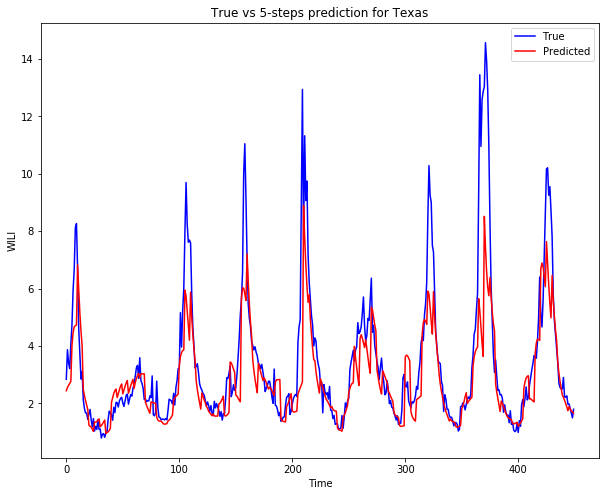

In [289]:
X_all = np.concatenate((data_dict_multi['X_train'],data_dict_multi['X_val'], data_dict_multi['X_test']))
y_all = np.concatenate((data_dict_multi['y_train'],data_dict_multi['y_val'], data_dict_multi['y_test']))
states_all = np.concatenate((data_dict_multi['states_train'],data_dict_multi['states_val'], data_dict_multi['states_test']))

plot_multiple_steps_preds_for_state(X_all, y_all.reshape(-1,TARGET_SIZE), states_all, seq2seq_att_shorter_hist, TARGET_SIZE, 'Texas', sc)


RMSES for each step = [0.59306882 0.85964691 1.03503439 1.17130962 1.26805885], average = 0.9854237211118921


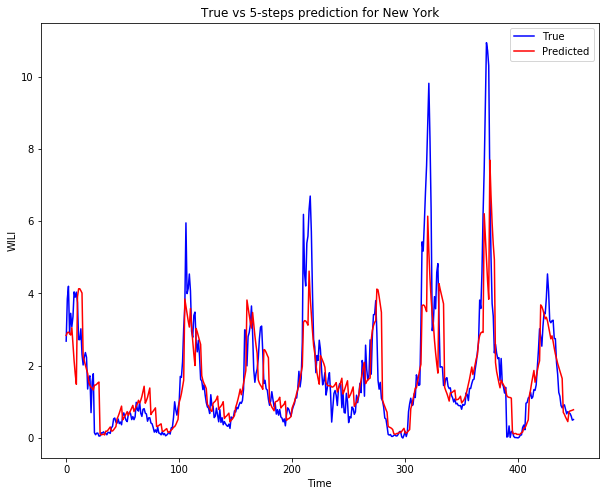

In [290]:
plot_multiple_steps_preds_for_state(X_all, y_all.reshape(-1,TARGET_SIZE), states_all, seq2seq_att_shorter_hist, TARGET_SIZE, 'New York', sc)
